In [87]:
import numpy as np
import scipy

import itertools

import matplotlib.pyplot as plt

In [88]:
# Parameters
L = 8
Nd = 4
Nc = 2

lattice_shape = tuple(L for _ in range(Nd))

beta = 5.5

# Scale for sampling matrices for use in metropolis algorithm
metropolis_step_size = 0.2

rng = np.random.default_rng(seed=0)

In [89]:
def trace(M):
    # Trace over the last dimension (by default np.trace traces over the first
    # two dimensions)
    return np.trace(M, axis1=-1, axis2=-2)

def adjoint(M):
    return np.conj(np.swapaxes(M, axis1=-1, axis2=-2))

def random_suN_element(scale, batch_shape):
    """
    Generates a random SU(N) element by sampling a gaussian Lie-algebra-valued
    field and exponentiating. Returns an array with shape (*batch_shape, Nc, Nc).

    The value of 'scale' determines how close the output will be to the identity
    -- if scale is small, then the output will be closer to the identity.

    Note that the output distribution is somewhat unclear, but this does not
    affect any of the uses of this function below.
    """
    shape = (*batch_shape, Nc, Nc)
    X = (rng.standard_normal(shape) + 1j * rng.standard_normal(shape)) / np.sqrt(2)
    # Project X to be Hermitian
    X = 0.5 * (X + adjoint(X))
    # Project X to be traceless
    # Note: broadcasting is very useful here (see https://numpy.org/doc/stable/user/basics.broadcasting.html)
    X = X - 1/Nc * trace(X)[...,None,None] * np.eye(Nc, Nc)
    # Now X is an element of the Lie algebra, so expm(X) will be in SU(N)
    return scipy.linalg.expm(1j * scale * X)

In [90]:
def wilson_action(U):
    result = 0
    for mu in range(Nd):
        for nu in range(mu):
            P_mu_nu = U[mu] @ np.roll(U[nu], -1, mu) @ np.roll(adjoint(U[mu]), -1, nu) @ adjoint(U[nu])
            result = result + np.sum(trace(P_mu_nu.real))
    return -beta / Nc * result

def plaquette(U):
    volume = np.prod(lattice_shape)
    num_plaq = volume * Nd * (Nd - 1) // 2
    return wilson_action(U) / num_plaq / (-beta)

In [91]:
def apply_gauge_transformation(U, g):
    """
    Takes a gauge field U and a gauge transformation g, and outputs the gauge
    transformed field defined by

        U'_\mu(x) = g(x) U_\mu(x) g(x + \hat{mu})

    Exercise: complete this function.
    """
    U_g = []
    for mu in range(Nd):
        U_g_mu = ...
        U_g.append(U_g_mu)
    return np.stack(U_g, axis=0)

# Note: for bigger projects, a testing framework like pytest
# (https://docs.pytest.org/en/stable/) is better than ad-hoc tests like this,
# but this approach works well enough for us here
def test_wilson_action_gauge_invariance():
    U = random_suN_element(scale=1.0, batch_shape=(Nd, *lattice_shape))
    g = random_suN_element(scale=1.0, batch_shape=lattice_shape)

    U_transformed = apply_gauge_transformation(U, g)

    action_initial = wilson_action(U)
    action_transformed = wilson_action(U_transformed)

    assert np.allclose(action_initial, action_transformed)
    print("[PASSED test_wilson_action_gauge_invariance]")

test_wilson_action_gauge_invariance()


[PASSED test_wilson_action_gauge_invariance]


In [92]:
# Create a mask that is 1 on even-parity sites, and 0 on odd-parity sites
even_mask = np.zeros(lattice_shape)
for parities in itertools.product([0, 1], repeat=Nd):
    idx = tuple(slice(parity, None, 2) for parity in parities)
    if sum(parities) % 2 == 0:
        even_mask[idx] = 1

In [116]:
def compute_staple(U, mu):
    """
    Computes the staple 'A(x)' for U_mu(x) such that the terms which involve
    U_mu(x) in the action can be written

        S(U) = tr(U_mu(x) A(x)) + (terms not involving U_mu(x))

    Exercise: complete this function.
    """
    ...

def test_staple():
    U = random_suN_element(scale=1.0, batch_shape=(Nd, *lattice_shape))

    action = 0
    for mu in range(Nd):
        staple_mu = compute_staple(U, mu)
        action = action + np.sum(trace(U[mu] @ staple_mu).real)
    
    # We count each plaquette 4 times
    action = action / 4

    assert np.allclose(action, wilson_action(U))
    print("[PASSED test_staple]")

test_staple()

ValueError: matmul: Input operand 1 does not have enough dimensions (has 0, gufunc core with signature (n?,k),(k,m?)->(n?,m?) requires 1)

In [94]:

def apply_metropolis_update(U, mu, mask):
    A = random_suN_element(metropolis_step_size, lattice_shape)

    staple = compute_staple(U, mu)
    U_mu_updated = A @ U[mu]

    S0 = trace(U[mu] @ staple).real
    S1 = trace(U_mu_updated @ staple).real
    dS = S1 - S0

    # Sample r from p(r) ~ e^{-r}, accept if \Delta S < r
    # Equivalently could also sample r uniformly on [0, 1], reject if r < e^{-\Delta S}
    draw = rng.exponential(size=lattice_shape)
    accept = dS < draw

    # Only update active links
    accept = np.logical_and(accept, mask)
    accept_rate = np.sum(accept) / np.sum(mask)
    
    U_mu_new = np.where(accept[...,None,None], U_mu_updated, U[mu])
    U[mu] = U_mu_new
    return U, accept_rate

def metropolis_sweep(U):
    acceptance = []
    for mu in range(Nd):
        U, accept = apply_metropolis_update(U, mu, even_mask)
        acceptance.append(accept)
        U, accept = apply_metropolis_update(U, mu, 1 - even_mask)
        acceptance.append(accept)
    return U, np.mean(acceptance)


In [98]:
# Warm/hot start -- U ~ uniform
U = random_suN_element(1.0, batch_shape=(Nd, *lattice_shape))

plaq_hot = []
for i in range(500):
    U, acceptance = metropolis_sweep(U)
    if i % 10 == 0 and i > 0:
        print(f"Iter {i} acceptance {acceptance:.3f} plaquette {np.mean(plaq_hot):.5f}")
    plaq_hot.append(plaquette(U))
plaq_hot = np.array(plaq_hot)

Iter 10 acceptance 0.698 plaquette 0.36873
Iter 20 acceptance 0.682 plaquette 0.47341
Iter 30 acceptance 0.694 plaquette 0.54635
Iter 40 acceptance 0.690 plaquette 0.59938
Iter 50 acceptance 0.681 plaquette 0.63930
Iter 60 acceptance 0.692 plaquette 0.67005
Iter 70 acceptance 0.681 plaquette 0.69464
Iter 80 acceptance 0.670 plaquette 0.71388
Iter 90 acceptance 0.670 plaquette 0.72917
Iter 100 acceptance 0.671 plaquette 0.74171
Iter 110 acceptance 0.678 plaquette 0.75211
Iter 120 acceptance 0.684 plaquette 0.76081
Iter 130 acceptance 0.679 plaquette 0.76829
Iter 140 acceptance 0.664 plaquette 0.77457
Iter 150 acceptance 0.666 plaquette 0.78008
Iter 160 acceptance 0.673 plaquette 0.78487
Iter 170 acceptance 0.676 plaquette 0.78912
Iter 180 acceptance 0.677 plaquette 0.79293
Iter 190 acceptance 0.668 plaquette 0.79628
Iter 200 acceptance 0.671 plaquette 0.79933
Iter 210 acceptance 0.680 plaquette 0.80201
Iter 220 acceptance 0.671 plaquette 0.80451
Iter 230 acceptance 0.674 plaquette 0.806

In [99]:
# Cold start -- U = identity
U = random_suN_element(0.0, batch_shape=(Nd, *lattice_shape))

plaq_cold = []
for i in range(1000):
    U, acceptance = metropolis_sweep(U)
    if i % 10 == 0 and i > 0:
        print(f"Iter {i} acceptance {acceptance:.3f} plaquette {np.mean(plaq_cold):.5f}")
    plaq_cold.append(plaquette(U))
plaq_cold = np.array(plaq_cold)

Iter 10 acceptance 0.671 plaquette 0.91893
Iter 20 acceptance 0.683 plaquette 0.89671
Iter 30 acceptance 0.670 plaquette 0.88609
Iter 40 acceptance 0.669 plaquette 0.88017
Iter 50 acceptance 0.670 plaquette 0.87619
Iter 60 acceptance 0.665 plaquette 0.87321
Iter 70 acceptance 0.684 plaquette 0.87107
Iter 80 acceptance 0.677 plaquette 0.86941
Iter 90 acceptance 0.663 plaquette 0.86803
Iter 100 acceptance 0.668 plaquette 0.86709
Iter 110 acceptance 0.667 plaquette 0.86624
Iter 120 acceptance 0.683 plaquette 0.86552
Iter 130 acceptance 0.670 plaquette 0.86493
Iter 140 acceptance 0.682 plaquette 0.86437
Iter 150 acceptance 0.685 plaquette 0.86381
Iter 160 acceptance 0.667 plaquette 0.86335
Iter 170 acceptance 0.674 plaquette 0.86304
Iter 180 acceptance 0.674 plaquette 0.86283
Iter 190 acceptance 0.683 plaquette 0.86259
Iter 200 acceptance 0.681 plaquette 0.86237
Iter 210 acceptance 0.674 plaquette 0.86220
Iter 220 acceptance 0.671 plaquette 0.86203
Iter 230 acceptance 0.660 plaquette 0.861

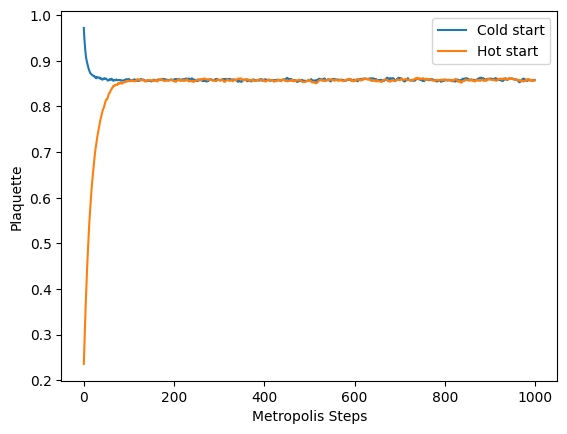

In [113]:
plt.plot(plaq_cold, label="Cold start")
plt.plot(plaq_hot, label="Hot start")
plt.xlabel("Metropolis Steps")
plt.ylabel("Plaquette")
plt.legend(loc="best")

Note that despite different initializations, the plaquette still converges to the same value